### Case study for 1d toy model

This is a case study for a toy model that describes a chirping waveform

$h(t;a,f,\dot{f},\epsilon) = a \sin (2\pi t[f + \dot{f}t](1 - \epsilon))$

Here $\epsilon \ll 1$ is used as a tuneable parameter allowing deviations from an exact model $h_{\text{e}}(t;\boldsymbol{\theta},\epsilon = 0)$ given by an approximate model $h_{\text{m}}(t;\boldsymbol{\theta}, \epsilon \neq 0)$. We only consider a single data stream and use the approximate lisa-like PSD.

Set $\epsilon = 10^{-6}$ as the approximate waveform model $h_{\text{m}}$ while $\epsilon = 0$ for the exact waveform model $h_{\text{e}}$.

Firstly we treat $\dot{f}$ as an unknown parameter and set the rest at the default values. So this is a 1d parameter inference problem.

| parameter | default_value | prior_distribution | prior_range|
|-----------|------------|--------------------|------------|
| $\dot{f}$ | $10^{-8}$  | uniform|$10^{-13}$|
| $a$ | $5\cdot 10^{-21}$  |-|-|
| $f$ | $10^{-3}$  | -|-|

#### generate the training dataset

To obtain the estimator, we need to have training set $\{d_{j}, c_{j}, \alpha_{j}\}$.
1. $\alpha_{j}$ is the nominal level; samples from $p(\alpha)$ (uniform defaulted)

2. $d_{j}$ is the data stream that contains the noise 
    1. samples from $p(d|\theta)$, $\theta_{j}$ are samples from the prior distribution $p(\theta)$
    2. the noise was considered when getting the $d_{j}$, i.e. $d_{j}=h(\theta_{j})+noise$

3. $c_{j}$ is the indicator of whether the Bayesian credible set approximation contains the $\theta_{j}$

#### Following is the process of generating 5000 samples and the test signal d_{o}

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from tqdm import tqdm

from utils import PowerSpectralDensity, FFT, freq_PSD, inner_prod, waveform
from cal_fun import deriv_waveform,Gaussian,llike
#----------------------------------------------------
###
# step 1
###
#Settings for simulation
#----------------------------------------------------
prior_sample_num=5000
prior_range=1e-13
fdot_true=1e-8
eps_true=1e-6

tmax =  120*60*60                 # Final time
fs = 2*1e-3                     # Sampling rate
delta_t = np.floor(0.01/fs)       # Sampling interval
t = np.arange(0,tmax,delta_t)     # Form time vector from t0 = 0 to t_{n-1} = tmax. Length N [include zero]

#----------------------------------------------------
###
# step 2
###
#generate the test signal
#the test signal is without noise
#----------------------------------------------------
h_true_t = waveform(fdot_true,t,0)
h_true_f = FFT(h_true_t) 
# the test signal d_{o} is without noise
data_f = h_true_f          # Construct data stream d_{o}

y_sample=np.zeros((prior_sample_num+1,len(data_f)))
y_sample[0]=data_f.real
c=np.zeros(prior_sample_num)
nominal_l=np.zeros(prior_sample_num)

#------------------------------------------------------------
###
# step 3
###
#simulation process
#for each loop simulation the dataset {\alpha, d, c}
#------------------------------------------------------------
for s in tqdm(range(prior_sample_num)):
    
    np.random.seed(s*2023)
    #------------------------------------------------------------
    # generate fdot_prior
    #------------------------------------------------------------

    fdot_prior_sample = np.random.uniform(1e-8-prior_range,1e-8+prior_range)  
    true_params = fdot_prior_sample

    #------------------------------------------------------------
    # generate simulated signal
    #------------------------------------------------------------
    tmax =  120*60*60                 # Final time
    fs = 2*1e-3                     # Sampling rate
    delta_t = np.floor(0.01/fs)       # Sampling interval
    t = np.arange(0,tmax,delta_t)     # Form time vector from t0 = 0 to t_{n-1} = tmax. Length N [include zero]
    N_t = int(2**(np.ceil(np.log2(len(t)))))   # Round length of time series to a power of two. 
                                            
    h_true_t = waveform(true_params,t,0)
    h_true_f = FFT(h_true_t)         # Compute true signal in frequency domain

    freq,PSD = freq_PSD(t,delta_t)  # Extract frequency bins and PSD.

    variance_noise_f = N_t * PSD / (4 * delta_t)            # Calculate variance of noise, real and imaginary.
    N_f = len(variance_noise_f)                             # Length of signal in frequency domain

    # Generate frequency domain noise
    noise_f = np.random.normal(0,np.sqrt(variance_noise_f),N_f) + 1j*np.random.normal(0,np.sqrt(variance_noise_f),N_f) 
    
    # samples of from 𝑝(𝑑|𝜃)
    data_f = h_true_f + noise_f  # Construct data stream for d_{j}
    
    y_sample[s+1]=data_f.real  # consider the real part, we also tried |d(j)|^2 and |d(j)| but did not gain any improvement in the results
    
    #------------------------------------------------------------
    # posterior distribution approximation by Fisher Matrix
    #------------------------------------------------------------

    # Fisher Matrix computation
    exact_deriv_fdot_est = (0.5) * (2*np.pi * t**2)*(1-eps_true) * deriv_waveform(true_params,t, np.pi/2,eps_true)
    deriv_fdot_fft_est = FFT(exact_deriv_fdot_est)
    deriv_vec_est = deriv_fdot_fft_est
    Fisher_Matrix_est = inner_prod(deriv_vec_est,deriv_vec_est,PSD,delta_t,N_t)
    Cov_Matrix_est = 1/Fisher_Matrix_est
    precision_est = np.sqrt(Cov_Matrix_est)

    # compute bias from the true_value
    h_approx_t = waveform(true_params,t, eps_true)    # Compute approximate waveform model 
    h_approx_f = FFT(h_approx_t)                      # Compute approximate model frequency domain
    residuals_f = h_true_f - h_approx_f+noise_f

    biass = inner_prod(deriv_vec_est,residuals_f,PSD,delta_t,N_t)
    bias_para = biass/Fisher_Matrix_est    # Compute bias
    
    # samples from  𝑝(𝛼)
    nominal=np.random.uniform(0.78,0.97)  
    nominal_l[s]=nominal

    #------------------------------------------------------------
    #calucate c_{j}: whether the approximate Bayesian credible set contains the \theta_{j}
    #------------------------------------------------------------
    if np.abs(bias_para)<=norm.ppf(1-(1-nominal)/2)*precision_est:
        c[s]=1

np.save("./c_samples.npy",c)
np.save("./y_samples.npy",y_sample)
np.save("./nominal_samples.npy",nominal_l)
print(np.mean(c))

### The data is ready, then train the model

#### dimension reduction
Here, we used tensorflow to build an autoencoder to make dimension reduction since the dimension of predictor is higher than a sample size, and the high dimension of the signals lead to the unbalanced information between nominal level and signals in input space.

In [2]:
import tensorflow as tf
tf.random.set_seed(123)
from tensorflow import keras
from keras.layers import Dense
from keras import Input, Model, regularizers,optimizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# normalization
scaler0 =StandardScaler()

y_sample=np.load("./y_samples.npy")
y_sample_s=scaler0.fit_transform(y_sample[1:])

# test signal d_{o}
yo=scaler0.transform(y_sample[0].reshape(1,-1))
# train signal d
ys=y_sample_s

print("the dimension of the signal",ys.shape[1],"is much larger than samplesize",ys.shape[0])


the dimension of the signal 65536 is much larger than samplesize 5000


#### build the autoencoder with activation of tanh and relu
`tanh` is a smooth activation function and can deal with negative values, so we used it in the first layer of encoder. Since `relu` is more simple, so it was used in the remaining layers. Regulations were used to reduce overfitting in the first and second layers of encoder.

In [3]:
# Building the Input Layer
input_layer= Input(shape=(65536,))

# encoded representation of input
encoded1 = Dense(2048, activation='tanh',activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded2 = Dense(512, activation='relu',activity_regularizer=regularizers.l1(10e-5))(encoded1)
encoded3 = Dense(64, activation='relu')(encoded2)
encoded = Dense(8, activation='relu')(encoded3)


# decoded representation of code 
decoded3 = Dense(64, activation='relu')(encoded)
decoded2 = Dense(512, activation='relu')(decoded3)
decoded1 = Dense(2048, activation='relu')(decoded2)
decoded = Dense(65536, activation='relu')(decoded1)
# Model which take input image and shows decoded images
autoencoder = Model(input_layer, decoded)

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65536)]           0         
_________________________________________________________________
dense (Dense)                (None, 2048)              134219776 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_5 (Dense)              (None, 512)               33280 

With larger dataset, `Adam` is more efficient and can combine the benefit of other two optimaizers: `AdaGrad` and `RMSprop`, which was used here.

In [4]:
#This model shows encoded signals
encoder = Model(input_layer, encoded)
# Creating a decoder model
encoded_input = Input(shape=(8,))
# last layer of the autoencoder model
decoder_layer = autoencoder.layers[-4]
# decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
#optimizer
opt = keras.optimizers.Adam(learning_rate=0.0001)

autoencoder.compile(optimizer=opt, loss='mse')

autoencoder.fit(ys, ys,
                epochs=3,
                batch_size=100,
                validation_split=0.05)

Epoch 1/3
48/48 [==============================] - 28s 452ms/step - loss: 1.1531 - val_loss: 1.1532
Epoch 2/3
48/48 [==============================] - 21s 439ms/step - loss: 1.1420 - val_loss: 1.1552
Epoch 3/3
48/48 [==============================] - 21s 443ms/step - loss: 1.1323 - val_loss: 1.1640


In [5]:
# encoding the sample signal ys and test signal yo
encoded_ys = encoder.predict(ys)
encoded_yo = encoder.predict(yo)

#### Adding nominal level as an input

In [6]:
nominal_sample=np.load("./nominal_samples.npy")
# set test nominal level at 80%,85%,90%,95%
nominalo=np.array(np.arange(0.80,1,0.05))

# trainset build
encoded_yo_total = np.repeat(encoded_yo,4,axis=0)

scaler =StandardScaler() #normalization

y_sample=np.concatenate((nominal_sample.reshape(-1,1), encoded_ys),axis=1) 
ys_encoder_s=scaler.fit_transform(y_sample)

# test signal
y_acc0=np.concatenate((nominalo.reshape(-1,1),encoded_yo_total),axis=1)
yo_encoder_s=scaler.transform(y_acc0) #noramlization

#### Adding training output $c_{j}$

In [7]:
c=np.load("./c_samples.npy")

### Classifier training
To make it simple, we used one-layer neural network with a sigmoid activation function here, actually, a logistic classifier.

In [8]:
# using sklearn to train classifier directly
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

clf = LogisticRegression().fit(ys_encoder_s, c)

### the realised operational coverage estimation for test signal with 80%,85%,90%,95% nominal levels
clf.predict_proba(yo_encoder_s)

array([[0.40923364, 0.59076636],
       [0.31717397, 0.68282603],
       [0.23749817, 0.76250183],
       [0.17277304, 0.82722696]])

#### another way to do logistic and ouput the estimation interval

In [9]:
import statsmodels.api as sm
X=sm.add_constant(ys_encoder_s)
cons=np.repeat(1.0,4)
Xo=np.concatenate((cons.reshape(-1,1),yo_encoder_s),axis=1)
# estimate the model
model = sm.Logit(c, X).fit()

proba=model.predict(Xo)
print(proba)

# estimation interval
cov = model.cov_params()
gradient = (proba * (1 - proba) * Xo.T).T # matrix of gradients for each observation
std_errors = np.array([np.sqrt(np.dot(np.dot(g, cov), g)) for g in gradient])
c = 1.96 # multiplier for confidence interval
upper = np.maximum(0, np.minimum(1, proba + std_errors * c))
lower = np.maximum(0, np.minimum(1, proba - std_errors * c))

print(upper)
print(lower)

Optimization terminated successfully.
         Current function value: 0.581121
         Iterations 5
[0.59063848 0.68280443 0.76256148 0.82733536]
[0.61810663 0.70176231 0.77995616 0.84629186]
[0.56317033 0.66384655 0.7451668  0.80837887]


### So the operational coverage estimation for test signals $d_{o}$ obtained

### Then how to get the realised operational coverage estimation?

For the test signal $d_{o}$:
1. Based on the MCMC, obtain the exact posterior samples $p(\boldsymbol{\theta}|d_o)$ and approximate credible intervals $\widehat{C}_{d_o}$
2. The realised operational coverage probability can be estimated by calculating the proportion of the samples that are inside credible intervals $\widehat{C}_{d_o}$.

In [10]:
import numpy as np
from utils import FFT, freq_PSD, inner_prod, waveform
from mcmc_fun_fdot import MCMC_run

np.random.seed(2023)
#----------------------------------------------------
###
# step 1
###
#Set true parameter
#we want to estimate it using MCMC
#----------------------------------------------------

fdot_true = 1e-8

# basic settings
tmax =  120*60*60                 # Final time
fs = 2*1e-3                       # Sampling rate
delta_t = np.floor(0.01/fs)       # Sampling interval 
t = np.arange(0,tmax,delta_t)     # Form time vector from t0 = 0 to t_{n-1} = tmax. Length N [include zero]
N_t = int(2**(np.ceil(np.log2(len(t)))))   # Round length of time series to a power of two 
                                           # Length of time series

#----------------------------------------------------
###
# step 2
###
# generate signal
#----------------------------------------------------
h_true_f = FFT(waveform(fdot_true,t))  # Compute true signal in frequency domain

freq,PSD = freq_PSD(t,delta_t)  # Extract frequency bins and PSD.

data_f = h_true_f    # Construct data stream d_{o}, test signal without noise

# This is the inputs d_{j}
data_y = data_f.real # only use real parts
                    

#----------------------------------------------------
###
# step 3
###
# MCMC - parameter estimation
#----------------------------------------------------


Ntotal = 21000  # Total number of iterations
burnin = 1000   # Set burn-in. This is the amount of samples we will discard whilst looking 
            # for the true parameters

variance_noise_f = N_t * PSD / (4 * delta_t)

delta_dotf = np.sqrt(1.007508992696005e-27)

fdot_start = fdot_true - 250*delta_dotf  # Starting values

fdot_chain,lp  = MCMC_run(data_f,t,0,variance_noise_f,
                            Ntotal, burnin, fdot_start,
                            printerval = 5000, save_interval = 50, 
                            fdot_var_prop = delta_dotf**2) 

fdot_chain_est,lp_est  = MCMC_run(data_f,t,1e-6, variance_noise_f,
                            Ntotal, burnin, fdot_start,
                            printerval = 5000, save_interval = 50, 
                            fdot_var_prop = delta_dotf**2)



sample1=fdot_chain_est[burnin::10]
sample0=fdot_chain[burnin::10]

#-----------------------------------------------------------------
###
# step 4
###
# calculate the proportion of the samples that are 
# inside credible intervals made by MCMC with approximate waveform
#-----------------------------------------------------------------

# hard code is not good
a95=0
a90=0
a85=0
a80=0
n=0
for i in range(sample0.shape[0]):
    n=n+1
    if sample0[i]>=np.percentile(sample1,[2.5,97.5])[0] and sample0[i]<=np.percentile(sample1,[2.5,97.5])[1]:
        a95=a95+1
    if sample0[i]>=np.percentile(sample1,[5,95])[0] and sample0[i]<=np.percentile(sample1,[5,95])[1]:
        a90=a90+1
    if sample0[i]>=np.percentile(sample1,[7.5,92.5])[0] and sample0[i]<=np.percentile(sample1,[7.5,92.5])[1]:
        a85=a85+1
    if sample0[i]>=np.percentile(sample1,[10,90])[0] and sample0[i]<=np.percentile(sample1,[10,90])[1]:
        a80=a80+1
exact_ratio=np.array([a80,a85,a90,a95])/n

exact_ratio


array([0.611 , 0.6725, 0.7495, 0.8375])

### The evaluation at the test signal $d_{o}$

([<matplotlib.axis.XTick at 0x7fb02c0ed940>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

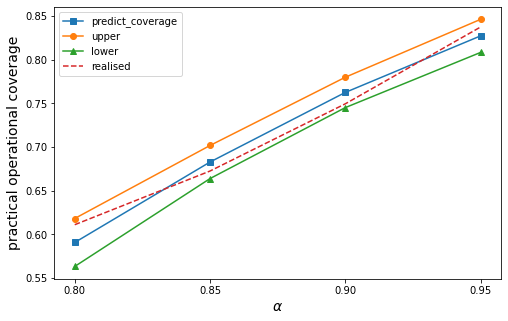

In [11]:
result=np.zeros((4,5))
result[:,0]=nominalo
result[:,1]=proba
result[:,2]=upper
result[:,3]=lower
result[:,4]=exact_ratio

import pandas as pd

df_yo = pd.DataFrame(result, columns = ['nominal','predict_coverage','upper','lower','realised'])

plt.rcParams["figure.figsize"] = (8,5)
df_yo.plot(x="nominal",style=['s-','o-','^-',"--"])
plt.ylabel('practical operational coverage',fontsize=14)
plt.xlabel(r"$\alpha$",fontsize=14)
plt.xticks([0.80,0.85,0.90,0.95])

## build the calibration curve
It is easy to obtain an inverse function of the logistic regression, using `logit` function

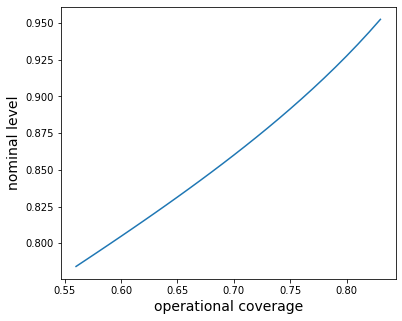

In [12]:
# inverse map ,take yo for example
def logit(p):
    return np.log(p / (1 - p))

def inverse_map(target):
    f=(logit(target)-np.dot(clf.coef_[:,1:],yo_encoder_s[1,1:])-clf.intercept_)/clf.coef_[:,0]
    x_vec=np.zeros(yo_encoder_s.shape[1])
    x_vec[0]=f
    X_vec=scaler.inverse_transform(x_vec)
    nominal=X_vec[0]
    return nominal

# the desired nominal level
ix=np.arange(0.56,0.84,0.01)
# the correct nominal level
iy=[inverse_map(ix[i]) for i in range(len(ix))]

plt.rcParams["figure.figsize"] = (6,5)
plt.plot(ix,iy)
# plt.title('nominal levels estimation',fontsize=20)
plt.xlabel("operational coverage",fontsize=14)
plt.ylabel("nominal level",fontsize=14)

plt.show()

### display the calibrated region

take desired nominal level at 0.8

In [13]:
alpha_new=inverse_map(0.8)


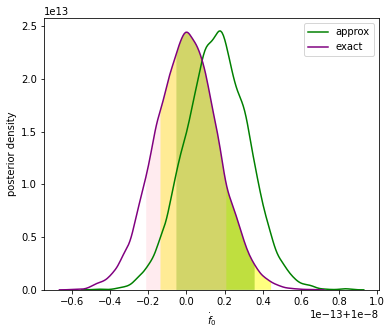

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

samples_est = fdot_chain_est[burnin::]
samples = fdot_chain[burnin::]

#----------------------------------------------------------
# get the credible interval for each posterior distribution]

lower_bound_est_new, upper_bound_est_new = np.percentile(samples_est, [(1-alpha_new)*50, (1-(1-alpha_new)/2)*100])
lower_bound_est, upper_bound_est = np.percentile(samples_est, [10, 90])
lower_bound, upper_bound = np.percentile(samples, [10, 90])

x1 =  np.arange(lower_bound, upper_bound, 1e-15)
kde1 = gaussian_kde(samples)
y1 = kde1.evaluate(x1)

x2 =  np.arange(lower_bound_est, upper_bound_est, 1e-15)
kde2 = gaussian_kde(samples_est)
y2 = kde1.evaluate(x2)

x3 =  np.arange(lower_bound_est_new, upper_bound_est_new, 1e-15)
y3 = kde1.evaluate(x3)

#------------------------------------------------------------
# Create a kernel density estimate plot of the data
# hard code to display the calibrated region, the yellow one is the calibrated region
# the calibrated region has the similar area as the original 0.8 credible interval made by MCMC with the exact waveform

sns.kdeplot(samples_est,c='green',label="approx")
sns.kdeplot(samples,c='purple',label="exact")
plt.fill_between(x2, y2, alpha=0.5,facecolor="green")
plt.fill_between(x3, y3, alpha=0.5,facecolor="yellow")
plt.fill_between(x1, y1, alpha=0.3,facecolor="pink")


plt.legend(loc='upper right')
plt.xlabel(r'$\dot{f}_{0}$')
plt.ylabel("posterior density")
plt.show()